In [ ]:
!pip install segmentation_models_pytorch

import os
from tqdm.notebook import tqdm
import gc
from torch.nn import Parameter
import torch.nn.functional as F
import torch.nn as nn
import math
import timm
import pandas as pl
import torch
import numpy as np
from torch.amp import GradScaler
import cv2
import random
from tqdm.notebook import tqdm
from torch.autograd import Variable
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import segmentation_models_pytorch as smp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ioai-2025-preparation-class-lesson-8-homework.zip

Archive:  /content/drive/MyDrive/ioai-2025-preparation-class-lesson-8-homework.zip
  inflating: data/test/000.jpg       
  inflating: data/test/001.jpg       
  inflating: data/test/002.jpg       
  inflating: data/test/003.jpg       
  inflating: data/test/004.jpg       
  inflating: data/test/005.jpg       
  inflating: data/test/006.jpg       
  inflating: data/test/007.jpg       
  inflating: data/test/008.jpg       
  inflating: data/test/009.jpg       
  inflating: data/test/010.jpg       
  inflating: data/test/011.jpg       
  inflating: data/test/012.jpg       
  inflating: data/test/013.jpg       
  inflating: data/test/014.jpg       
  inflating: data/test/015.jpg       
  inflating: data/test/016.jpg       
  inflating: data/test/017.jpg       
  inflating: data/test/018.jpg       
  inflating: data/test/019.jpg       
  inflating: data/test/020.jpg       
  inflating: data/test/021.jpg       
  inflating: data/test/022.jpg       
  inflating: data/test/023.jpg       
  inf

In [ ]:
train_msk = np.load('/content/msk_array.npy')
train_images = sorted(os.listdir('/content/data/train/'))
test_images = sorted(os.listdir('/content/data/test/'))
test_msk = np.zeros((len(test_images), train_msk.shape[1], train_msk.shape[2]))

train_images = [f'/content/data/train/{path}' for path in train_images]
test_images = [f'/content/data/test/{path}' for path in test_images]
len(train_images)


545

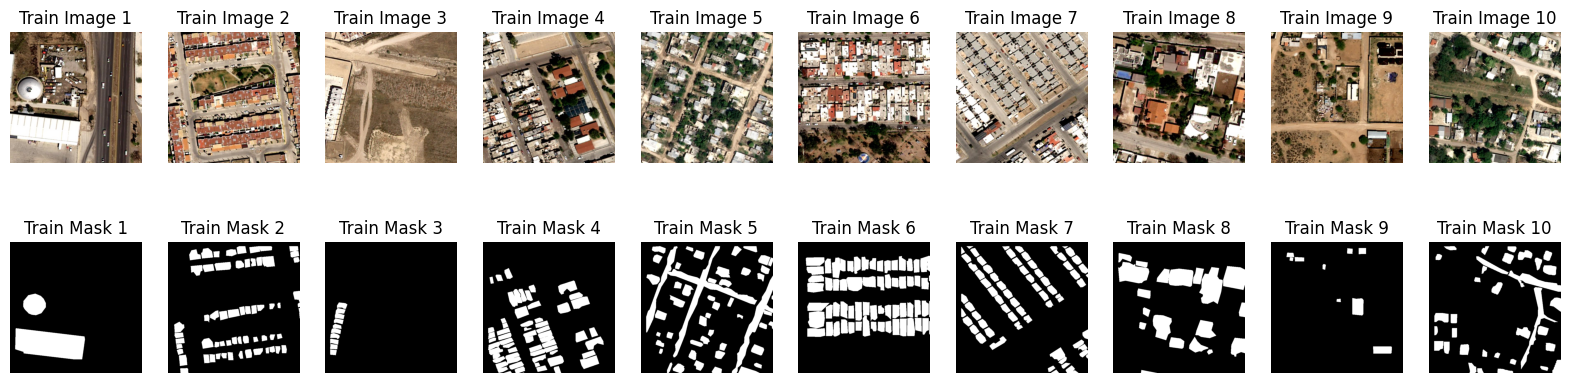

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Визуализация первых 10 изображений и масок
plt.figure(figsize=(20, 5))
for i in range(10):
    # Отображение изображения
    plt.subplot(2, 10, i + 1)
    img = plt.imread(train_images[i])
    plt.imshow(img)
    plt.title(f'Train Image {i+1}')
    plt.axis('off')

    # Отображение маски
    plt.subplot(2, 10, i + 11)
    plt.imshow(train_msk[i], cmap='gray')
    plt.title(f'Train Mask {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
from torchvision import transforms

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path_image, msks, image_size=512):
        self.path_image = path_image
        self.msks = msks
        self.image_size = image_size

        # Нормализация для ImageNet
        self.mean = [0.485, 0.456, 0.406]  # Средние значения для ImageNet
        self.std = [0.229, 0.224, 0.225]    # Стандартные отклонения для ImageNet

        # Преобразования для изображений
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Конвертирует numpy array в тензор и нормализует в [0, 1]
            transforms.Normalize(mean=self.mean, std=self.std)  # Нормализация для ImageNet
        ])

    def __len__(self):
        return len(self.path_image)

    def __getitem__(self, i):
        # Загрузка изображения
        img = cv2.imread(self.path_image[i])
        if img is None:
            raise FileNotFoundError(f"Image at path {self.path_image[i]} not found or could not be loaded.")

        # Загрузка маски
        msk = self.msks[i]
        if len(msk.shape) == 2:
            msk = msk[:, :, None]
        elif msk.shape[2] != 1:
            msk = msk[:, :, 0:1]  # Берем только первый канал, если их несколько

        # Ресайз изображения и маски
        img = cv2.resize(img, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        msk = cv2.resize(msk, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        # Преобразование изображения
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV загружает в BGR, преобразуем в RGB
        img = self.transform(img)  # Применяем нормализацию и преобразование в тензор

        # Преобразование маски
        msk = torch.from_numpy(msk.astype(np.float32))

        return img, msk

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()


        self.unet = smp.Unet('efficientnet-b3',
                             encoder_weights='imagenet',
                             classes=1,
        )

    def forward(self, x):
        y = self.unet(x)
        return y

In [ ]:
gc.collect()
torch.cuda.empty_cache()

batch_size = 4
valid_batch_size = 4
epochs = 10
lr = 0.0352
clip_grad_norm = 15.28

params_train = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2}
params_val = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2}

#train_loader = torch.utils.data.DataLoader(Dataset(train_images[:-70], train_msk[:-70]), **params_train)
#val_loader = torch.utils.data.DataLoader(Dataset(train_images[-70:], train_msk[-70:]), **params_val)

In [ ]:
indices = np.arange(len(train_images))
np.random.shuffle(indices)  # Перемешиваем индексы

train_indices = indices[:-70]
val_indices = indices[-70:]

train_loader = torch.utils.data.DataLoader(Dataset([train_images[i] for i in train_indices], [train_msk[i] for i in train_indices]), **params_train)
val_loader = torch.utils.data.DataLoader(Dataset([train_images[i] for i in val_indices], [train_msk[i] for i in val_indices]), **params_val)

In [ ]:
DEVICE='cuda'

In [ ]:
from sklearn.metrics import f1_score
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

In [ ]:
# Определение устройства
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели
model = Model().to(DEVICE)

# Вычисление количества шагов обучения
num_train_steps = int(len(train_loader) / batch_size * epochs)

# Функция потерь
loss_func = smp.losses.DiceLoss(mode="binary", smooth=1.)

# Инициализация GradScaler для mixed precision
scaler = GradScaler('cuda')

# Оптимизатор и планировщик
optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs, 1e-6)

# Функция валидации
def validate(model, val_loader, loss_func, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img, target in val_loader:
            img = img.to(device)
            target = target.to(device)
            outputs = model(img)
            loss = loss_func(outputs, target)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Цикл обучения
for epoch in range(epochs):
    model.train()
    average_loss = 0
    tk0 = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_number, (img, target) in tk0:
        optimizer.zero_grad()
        img = img.to(DEVICE)
        target = target.to(DEVICE)

        # Mixed precision training
        with autocast():
            outputs = model(img)
            loss = loss_func(outputs, target)

        # Backpropagation с GradScaler
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        # Обновление планировщика
        scheduler.step()

        # Обновление среднего значения потерь
        average_loss += loss.cpu().detach().numpy()
        tk0.set_postfix(loss=average_loss / (batch_number + 1), lr=scheduler.get_last_lr()[0], stage="train", epoch=epoch)

    # Валидация
    val_loss = validate(model, val_loader, loss_func, DEVICE)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss / len(train_loader)}, Val Loss: {val_loss}")

<ipython-input-61-f221969c1a59>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/119 [00:00<?, ?it/s]<ipython-input-61-f221969c1a59>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 119/119 [00:29<00:00,  4.08it/s, epoch=0, loss=0.421, lr=0.0343, stage=train]


Epoch 1/10, Train Loss: 0.42121196895086466, Val Loss: 0.7252853711446127


100%|██████████| 119/119 [00:27<00:00,  4.38it/s, epoch=1, loss=0.341, lr=0.0318, stage=train]


Epoch 2/10, Train Loss: 0.34095175176107584, Val Loss: 0.5195784635014005


100%|██████████| 119/119 [00:32<00:00,  3.66it/s, epoch=2, loss=0.309, lr=0.0279, stage=train]


Epoch 3/10, Train Loss: 0.30857582903709735, Val Loss: 0.36743807461526656


100%|██████████| 119/119 [00:30<00:00,  3.90it/s, epoch=3, loss=0.302, lr=0.023, stage=train]


Epoch 4/10, Train Loss: 0.30228292691607433, Val Loss: 0.2908553414874607


100%|██████████| 119/119 [00:27<00:00,  4.33it/s, epoch=4, loss=0.299, lr=0.0176, stage=train]


Epoch 5/10, Train Loss: 0.29926341020760416, Val Loss: 0.3086426887247298


100%|██████████| 119/119 [00:27<00:00,  4.34it/s, epoch=5, loss=0.271, lr=0.0122, stage=train]


Epoch 6/10, Train Loss: 0.2708950203006007, Val Loss: 0.2691523532072703


100%|██████████| 119/119 [00:27<00:00,  4.26it/s, epoch=6, loss=0.261, lr=0.00726, stage=train]


Epoch 7/10, Train Loss: 0.26076647764494437, Val Loss: 0.3501975999938117


100%|██████████| 119/119 [00:27<00:00,  4.29it/s, epoch=7, loss=0.254, lr=0.00336, stage=train]


Epoch 8/10, Train Loss: 0.2536057318959917, Val Loss: 0.2915422022342682


100%|██████████| 119/119 [00:27<00:00,  4.32it/s, epoch=8, loss=0.241, lr=0.000862, stage=train]


Epoch 9/10, Train Loss: 0.24114083442367426, Val Loss: 0.2578851580619812


100%|██████████| 119/119 [00:29<00:00,  4.02it/s, epoch=9, loss=0.235, lr=1e-6, stage=train]


Epoch 10/10, Train Loss: 0.23454057368911616, Val Loss: 0.24141956037945217


In [ ]:
params_val = {'batch_size': batch_size, 'shuffle': False, 'drop_last': False, 'num_workers': 2}
test_loader = torch.utils.data.DataLoader(Dataset(test_images, test_msk), **params_val)

In [ ]:
preds = []
imgs_list = []
target_list = []
model.eval()
average_loss = 0
with torch.no_grad():
    for batch_number,  (img, target)  in enumerate(test_loader):
        img = img.to(DEVICE)
        target = target.to(DEVICE)

        with torch.amp.autocast('cuda'):
            outputs = model(img)

        preds += [outputs.sigmoid().to('cpu').numpy()]

preds = np.concatenate(preds)[:, 0, ...]

In [ ]:
preds = (preds > 0.2).astype(np.uint8)

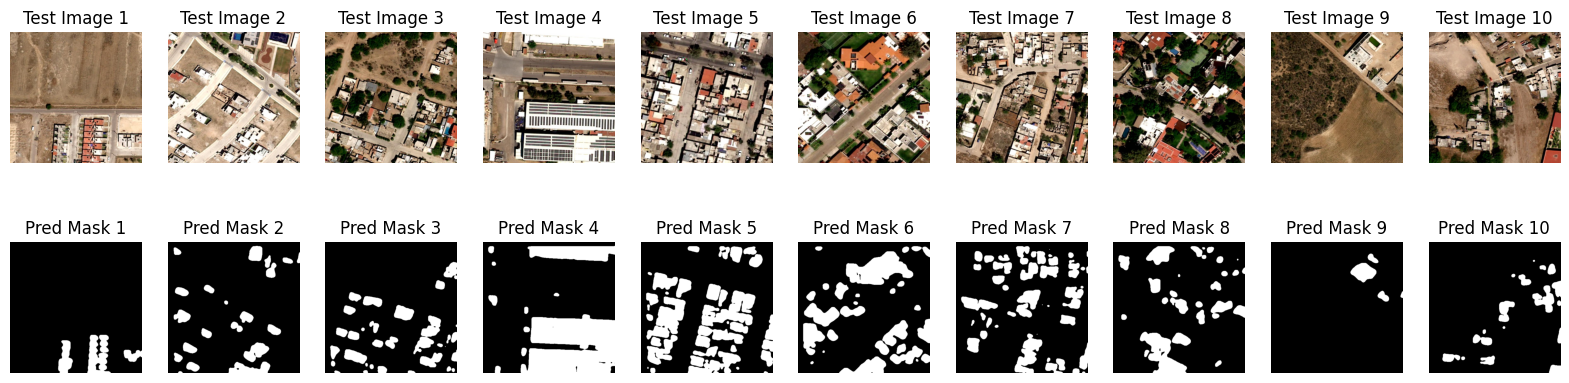

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(10):
    # Отображение тестового изображения
    plt.subplot(2, 10, i + 1)
    img = plt.imread(test_images[i])
    plt.imshow(img)
    plt.title(f'Test Image {i+1}')
    plt.axis('off')

    # Отображение предсказанной маски
    plt.subplot(2, 10, i + 11)
    plt.imshow(preds[i], cmap='gray')
    plt.title(f'Pred Mask {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [ ]:
true_list = [list_to_string(rle_encode(ans)) for ans in preds]

predict_df = pd.DataFrame()
predict_df['Id'] = [f'{x:03d}.jpg' for x in range(150)]
predict_df['Target'] = true_list
predict_df.to_csv('submission.csv', index = None)

#Модель с hf

In [ ]:
from transformers import AutoImageProcessor, DetrForSegmentation
from transformers.image_transforms import rgb_to_id
import torch
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, DetrForSegmentation
from torch.optim import AdamW
from tqdm import tqdm



In [ ]:
# Загрузка предварительно обученного процессора и модели
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/172M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor

# Загрузка данных
train_image_dir = "data/train"
test_image_dir = "data/test"
train_masks = np.load("msk_array.npy")  # Загрузка масок для обучения

# Список путей к изображениям
train_image_paths = [os.path.join(train_image_dir, img) for img in os.listdir(train_image_dir)]
test_image_paths = [os.path.join(test_image_dir, img) for img in os.listdir(test_image_dir)]

# Разделение данных на обучающую и валидационную выборки
train_image_paths, val_image_paths, train_masks, val_masks = train_test_split(
    train_image_paths, train_masks, test_size=0.2, random_state=42
)

# Пользовательский Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, masks, processor, transform=None):
        self.image_paths = image_paths
        self.masks = masks
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Загрузка изображения
        image = Image.open(self.image_paths[idx]).convert("RGB")
        # Загрузка маски
        mask = self.masks[idx]

        # Предобработка изображения и маски
        inputs = self.processor(images=image, segmentation_maps=mask, return_tensors="pt")

        # Возвращаем pixel_values и labels
        return {
            "pixel_values": inputs["pixel_values"].squeeze(),  # Убираем batch dimension
            "labels": inputs["pixel_mask"].squeeze(),  # Убираем batch dimension
        }

# Загрузка предварительно обученного процессора
processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50-panoptic")

# Создание Dataset
train_dataset = SegmentationDataset(train_image_paths, train_masks, processor)
val_dataset = SegmentationDataset(val_image_paths, val_masks, processor)
test_dataset = SegmentationDataset(test_image_paths, np.zeros((len(test_image_paths), 1, 1)), processor)  # Маски для теста не используются

# Создание DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Проверка
print(f"Train batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Train batches: 109
Validation batches: 28
Test batches: 38


In [ ]:
# Определение оптимизатора
optimizer = AdamW(model.parameters(), lr=5e-5)
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
# Определение устройства (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Цикл обучения
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Перемещение данных на устройство
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        with autocast():
          outputs = model(pixel_values=pixel_values, labels=labels)
          loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")

    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            val_loss += outputs.loss.item()

    print(f"Validation Loss: {val_loss / len(val_dataloader)}")

# Сохранение модели
model.save_pretrained("path_to_save_model")
image_processor.save_pretrained("path_to_save_model")

<ipython-input-41-92d7f22b489e>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/3:   0%|          | 0/109 [00:00<?, ?it/s]Unused or unrecognized kwargs: segmentation_maps.
Unused or unrecognized kwargs: segmentation_maps.
Unused or unrecognized kwargs: segmentation_maps.
Unused or unrecognized kwargs: segmentation_maps.
<ipython-input-41-92d7f22b489e>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3:   0%|          | 0/109 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.91 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.03 GiB is free. Process 20438 has 13.71 GiB memory in use. Of the allocated memory 10.95 GiB is allocated by PyTorch, and 2.63 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#Yolo сегментация


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 21.4 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolo11n-seg.pt")

100%|██████████| 5.90M/5.90M [00:00<00:00, 87.4MB/s]


In [ ]:
from PIL import Image

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Пути к данным
train_image_dir = "data/train"
test_image_dir = "data/test"
train_masks = np.load("msk_array.npy")  # Загрузка масок

# Создание структуры папок
os.makedirs("dataset/images/train", exist_ok=True)
os.makedirs("dataset/images/val", exist_ok=True)
os.makedirs("dataset/labels/train", exist_ok=True)
os.makedirs("dataset/labels/val", exist_ok=True)

# Функция для преобразования масок в YOLO формат
def mask_to_yolo_format(mask, class_id):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    yolo_annotations = []
    for contour in contours:
        contour = contour.squeeze()
        contour = contour / np.array([mask.shape[1], mask.shape[0]])  # Нормализация
        contour = contour.flatten().tolist()
        yolo_annotations.append([class_id] + contour)
    return yolo_annotations

# Разделение данных на train и val
train_image_paths = [os.path.join(train_image_dir, img) for img in os.listdir(train_image_dir)]
train_image_paths, val_image_paths, train_masks, val_masks = train_test_split(
    train_image_paths, train_masks, test_size=0.2, random_state=42
)

# Сохранение изображений и аннотаций
for image_paths, masks, split in zip(
    [train_image_paths, val_image_paths], [train_masks, val_masks], ["train", "val"]
):
    for image_path, mask in zip(image_paths, masks):
        # Копирование изображений
        image_name = os.path.basename(image_path)
        new_image_path = os.path.join("dataset/images", split, image_name)
        os.rename(image_path, new_image_path)

        # Преобразование масок и сохранение аннотаций
        yolo_annotations = mask_to_yolo_format(mask, class_id=0)  # class_id=0 для одного класса
        label_path = os.path.join("dataset/labels", split, os.path.splitext(image_name)[0] + ".txt")
        with open(label_path, "w") as f:
            for ann in yolo_annotations:
                f.write(" ".join(map(str, ann)) + "\n")

In [ ]:
data_yaml = f"""
path: /content/dataset
train: images/train
val: images/val
test: images/test

names:
  0: object
"""
with open(os.path.join('/content/data', 'data.yaml'), 'w') as f:
    f.write(data_yaml)

In [ ]:
torch.use_deterministic_algorithms(False)

In [ ]:
results = model.train(
    data='/content/data/data.yaml',  # Путь к конфигурационному файлу
    epochs=5,        # Количество эпох
    imgsz=256,         # Размер изображения
    batch=16,
    device='0'
)

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/data/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 19.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.9MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/labels/train... 436 images, 1 backgrounds, 0 corrupt: 100%|██████████| 436/436 [00:01<00:00, 262.69it/s]


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val... 109 images, 1 backgrounds, 0 corrupt: 100%|██████████| 109/109 [00:00<00:00, 212.11it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.88G      4.118      5.108      3.527      2.347        126        256: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        109       2243    0.00715     0.0892    0.00494    0.00193   0.000501    0.00624   0.000252    5.4e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.14G      3.911      4.569      3.332      1.951        174        256: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        109       2243     0.0128      0.187     0.0079    0.00191    0.00942      0.137    0.00551    0.00112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.24G       3.88      4.477      3.132      1.745        114        256: 100%|██████████| 28/28 [00:26<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


                   all        109       2243     0.0123      0.179    0.00794    0.00188    0.00823       0.12    0.00506    0.00106

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.07G      3.846      4.425      2.973      1.674        119        256: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


                   all        109       2243     0.0121      0.177     0.0081    0.00195    0.00955      0.139    0.00573    0.00122

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.14G      3.819      4.405      2.901      1.643        144        256: 100%|██████████| 28/28 [00:26<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        109       2243      0.013      0.189    0.00819    0.00198     0.0115      0.167    0.00681    0.00153



5 epochs completed in 0.042 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 5.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 5.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


                   all        109       2243      0.013       0.19    0.00821    0.00199     0.0115      0.168    0.00686    0.00153
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/segment/train


In [ ]:
model = YOLO("runs/segment/train/weights/best.pt")

# Предикт на тестовых данных
results = model.predict(
    task = 'segment',
    source="/content/data/test",
    save=True,  # Сохранить результаты
    conf=0.01,  # Порог уверенности
    show_labels=True,
    show_conf=True,
)

SyntaxError: '[31m[1mfont_size[0m' is not a valid YOLO argument. 

    Arguments received: ['yolo', '-f', '/root/.local/share/jupyter/runtime/kernel-e860d0a9-4c12-4ce0-af64-c0fab07fda6a.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of frozenset({'segment', 'pose', 'detect', 'obb', 'classify'})
                MODE (required) is one of frozenset({'predict', 'val', 'train', 'benchmark', 'export', 'track'})
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo11n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo11n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo11n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLO11n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolo11n-cls.pt format=onnx imgsz=224,128

    5. Ultralytics solutions usage
        yolo solutions count or in ['heatmap', 'queue', 'speed', 'workout', 'analytics', 'trackzone', 'inference'] source="path/to/video/file.mp4"

    6. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg
        yolo solutions help

    Docs: https://docs.ultralytics.com
    Solutions: https://docs.ultralytics.com/solutions/
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)